<a href="https://colab.research.google.com/github/han-juyoung/Aimers_Lectures/blob/main/Image_Project_GPR(%EC%A7%80%ED%91%9C%ED%88%AC%EA%B3%BC%EB%A0%88%EC%9D%B4%EB%8D%94)_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%A7%A4%EC%84%A4%EB%AC%BC_%ED%83%90%EC%A7%80_CNN_%EB%AA%A8%EB%8D%B8_%EA%B0%9C%EB%B0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

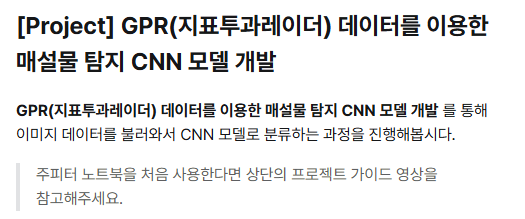

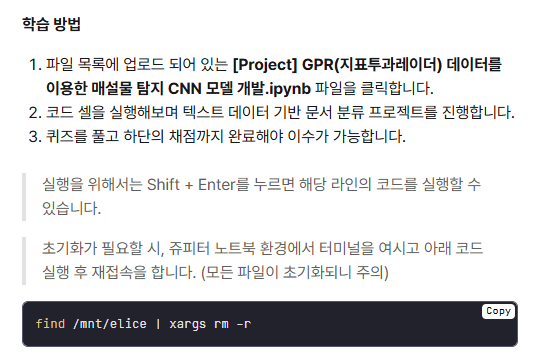

In [ ]:
# tensorflow 2.11 버전에서 테스트되었습니다.
# 컨테이너에 텐서플로 버전을 맞춰주세요.

%pip install numpy==1.23.5
%pip install tensorflow==2.11.0

     |████████████████████████████████| 17.1 MB 7.1 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.0 requires numpy~=1.19.2, but you have numpy 1.23.5 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 588.3 MB 25 kB/s  eta 0:00:0112
     |████████████████████████████████| 439 kB 105.2 MB/s eta 0:00:01
     |████████████████████████████████| 24.5 MB 79.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 83.9 MB/s eta 0:00:01


# [Project] GPR(지표투과레이더) 데이터를 이용한 매설물 탐지 CNN 모델 개발

---

## 프로젝트 목적
  
  - 지하탐지 분야에서 주목받고 있는 GPR(Ground Pentrating Rader) 데이터 에서 딥러닝 기반의 CNN (Convolution Neural Network) 를 이용하여 배관 등의 매설 위치를 파악하는 프로젝트를 수행합니다.

---

## 데이터 출처

  - https://github.com/rpl-cmu/CMU-GPR-Dataset

---

## 프로젝트 개요

  - GPR 데이터의 형식에 대해서 알아보고 이를 이미지로 시각화(visualization) 하는 방법에 대해서 배웁니다.
    
  - CNN network 모델을 정의하고, 레이블링한 데이터를 이용하여 학습을 진행한다.
  
  - 학습된 모델로 추론(inference) 하는 방법을 알아봅니다.

---

## 데이터 베이스

  - CMU GPR dataset은 GPR 센서의 측정 결과와 측정 위치를 레이블링한 데이터 입니다.
  
  - 본 데이터는 GPR을 측정한 정확한 위치가 함께 레이블링 되어 있으나 그 속에 무었이 있는지에 대한 정보를 가지고 있지는 않습니다.

---

In [ ]:
!pip install --upgrade aiohttp

     |████████████████████████████████| 1.3 MB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 319 kB 107.8 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 102.2 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 106.3 MB/s eta 0:00:01
     |████████████████████████████████| 213 kB 102.6 MB/s eta 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [ ]:
# %matplotlib notebook
import matplotlib.pyplot as plt
# 엘리스 환경에서 한글 폰트를 사용하기 위한 코드입니다.

import matplotlib.font_manager as fm
font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 1. 데이터 분석 및 시각화

  - GPR은 전자파를 지면에 방출 시켜서 되돌아 오는 반사파를 기록합니다.
  - 만일 지하에 무엇인가 매질이 다른 물질이 있으면 되돌아오는 반사파의 형태가 변하게 됩니다.
  - 되돌아오는 반사파의 형태를 분석하면 지하에 무엇이 매설되어 있는지를 추측할 수 있습니다.
  
  
  - GPR로 측정한 데이터의 형태를 조사해 봅니다.

In [ ]:
# GPR 센서의 측정 데이터를 읽어 봅니다.
df = pd.read_csv("./data/gpr_meas.csv", index_col=0)

# 데이터에 들어 있는 값을 확인해 봅니다.
df.head()

,Amp_0,Amp_1,Amp_2,Amp_3,Amp_4,Amp_5,Amp_6,Amp_7,Amp_8,Amp_9,...,Amp_191,Amp_192,Amp_193,Amp_194,Amp_195,Amp_196,Amp_197,Amp_198,Amp_199,Amp_200
Time[s],,,,,,,,,,,,,,,,,,,,,
1.613064e+09,-17.0,-45.0,-95.0,-93.0,144.0,272.0,-178.0,14.0,2119.0,8765.0,...,-102.0,-121.0,-140.0,-147.0,-144.0,-153.0,-143.0,-86.0,-142.0,-128.0
1.613064e+09,0.0,-56.0,-136.0,-58.0,131.0,226.0,-172.0,65.0,2456.0,7835.0,...,-104.0,-147.0,-162.0,-173.0,-129.0,-120.0,-97.0,-148.0,-121.0,-142.0
1.613064e+09,-67.0,-117.0,-194.0,-107.0,129.0,129.0,-258.0,491.0,3304.0,8575.0,...,-189.0,-252.0,-258.0,-233.0,-226.0,-208.0,-168.0,-181.0,-168.0,-160.0
1.613064e+09,-34.0,-87.0,-149.0,-83.0,99.0,221.0,-221.0,256.0,2725.0,8815.0,...,-167.0,-201.0,-203.0,-202.0,-170.0,-187.0,-133.0,-148.0,-166.0,-175.0
1.613064e+09,-63.0,-77.0,-151.0,-112.0,139.0,222.0,-127.0,169.0,2184.0,8446.0,...,-174.0,-169.0,-223.0,-263.0,-223.0,-208.0,-188.0,-190.0,-209.0,-180.0


In [ ]:
# 데이터의 평균/분산/최소값/최대값 등 기본적인 통계량을 확인해 봅니다.
df.describe()

,Amp_0,Amp_1,Amp_2,Amp_3,Amp_4,Amp_5,Amp_6,Amp_7,Amp_8,Amp_9,...,Amp_191,Amp_192,Amp_193,Amp_194,Amp_195,Amp_196,Amp_197,Amp_198,Amp_199,Amp_200
count,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.0000,3100.000000,3100.000000,...,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000
mean,8.293226,-33.916774,-104.092258,-107.942903,41.350323,268.614194,19.322581,-88.1200,1393.509355,6038.399355,...,-69.886452,-75.011613,-83.388065,-91.415484,-101.865806,-114.988387,-128.113226,-138.872581,-149.500968,-157.791613
std,82.105934,80.732070,73.444251,60.575467,49.378276,31.280928,121.908171,229.0322,624.852776,1145.671881,...,92.647462,94.478531,95.802078,96.770939,96.807651,97.504880,99.857619,99.864136,99.245506,97.580692
min,-710.000000,-738.000000,-714.000000,-502.000000,-93.000000,107.000000,-514.000000,-1131.0000,-600.000000,2448.000000,...,-773.000000,-816.000000,-777.000000,-806.000000,-791.000000,-807.000000,-837.000000,-835.000000,-827.000000,-800.000000
25%,-43.000000,-84.000000,-151.000000,-147.000000,7.000000,251.000000,-46.000000,-196.0000,1050.000000,5359.500000,...,-128.000000,-136.000000,-147.000000,-152.000000,-159.000000,-170.000000,-187.000000,-200.250000,-210.000000,-217.000000
50%,-4.000000,-48.000000,-116.000000,-116.000000,34.000000,269.000000,44.000000,-50.0000,1356.000000,5985.500000,...,-83.000000,-91.000000,-98.000000,-106.000000,-116.000000,-128.000000,-137.000000,-146.000000,-156.000000,-165.000000
75%,43.000000,3.000000,-71.000000,-80.000000,69.000000,287.000000,106.000000,56.0000,1681.250000,6621.250000,...,-21.000000,-20.000000,-28.000000,-41.750000,-56.000000,-73.000000,-85.000000,-95.000000,-104.000000,-115.000000
max,365.000000,307.000000,228.000000,170.000000,262.000000,552.000000,377.000000,1810.0000,6721.000000,13401.000000,...,297.000000,290.000000,297.000000,286.000000,317.000000,322.000000,337.000000,290.000000,247.000000,229.000000


  - gpr_meas.csv 파일에는 GPR에서 측정한 200개의 반사된 주파수의 시간별 amplitude(진폭)가 저장되어 있습니다.
  
  - Amp_0 와 Amp_3 컬럼을 비교해 보면 평균(mean)/분산(std)이 각각 8.29/82.105, -107.94,/60.57로 주파수에 따른 통계적 특성이 제각각 다름을 알 수 있습니다.
  
  - Amp_0, Amp_10, Amp_100 컬럼의 시간에 따른 값 변화를 표시해 봅니다.

<AxesSubplot:xlabel='Time[s]'>

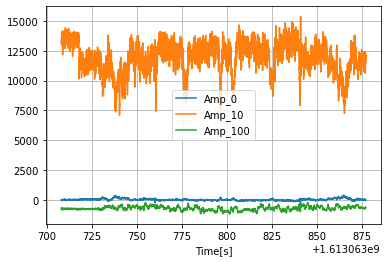

In [ ]:
df[['Amp_0','Amp_10', 'Amp_100']].plot(grid='on')

  - Amp_10 컬럼의 주파수의 amplitude의 변화를 보면 779, 848 등의 위치에서 그 신호가 급격하게 떨어지는 현상을 확인할 수 있습니다.
  
  - Amp_0 부터 Amp_200까지의 column을 모으면 2D matrix 형태이기 때문에 이미지형태로 변환할 수 있습니다.
    -  아래 코드는 전체 200개의 주파수에 대한 데이터를 최대/최소값을 지정하여  normalization(정규화)한 이미지를 표시합니다.

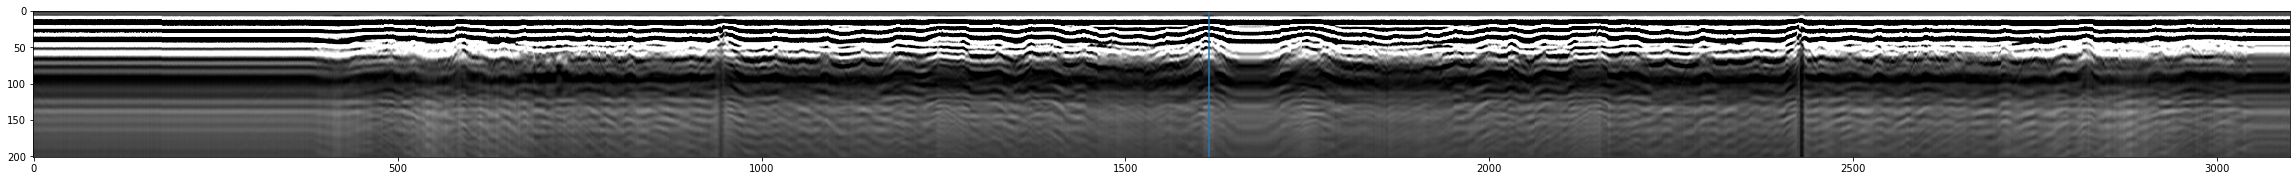

In [ ]:
# df.values는 df의 전체 column을 matrix 형태로 변환합니다.
# 이렇게만 하면 Y축 방향이 시간이 되기 때문에 아래쪽으로 긴 이미지가 만들어 집니다.
# 따라서 matrix를 transpose 하여 보기 편하도록 matrix의 모양을 변경합니다.
image_like_data = df.values.T

#최대/최소값을 지정하여 그 사이의 값이 0과 1사이가 되도록 min-max normalization을 수행합니다.
# 주파수의 최소~최대 차이가 너무 크기 때문에 맞춰준다. 맞춰주지 않으면 주파수가 큰 데이터만 두드러진다.
(vmax, vmin) = (2500, -1000)
norm_img = (image_like_data - vmin)/(vmax-vmin)

# min-mix normalization만을 수행하면 최대/최소값을 넘어가는 데이터로 인하여 visulization이 잘 되지 않는 경우가 있습니다.
# 따라서 최대/최소값을 넘어가는 데이터는 그 값을 적절하게 조절합니다.
# clip 은 1이 넘어가면 모두 바꿔 준다. 0보다 작은 값은 0으로 1보다 큰 값은 1로 만들어줌.
clipped_img = np.clip(0,1, norm_img)

# GPR sensor 데이터를 이미지 형태로 변환한 결과를 출력합니다.
plt.figure(figsize=(32, 4))
plt.imshow(clipped_img, cmap='gray', vmax=1, vmin=0.0)
plt.axvline(x=1615) # 설명을 위한 표시 추가
plt.tight_layout()

  - 위의 코드에서 최대/최소값을 변경하는 것으로도 이미지의 형태가 상이하게 변하는 것을 확인 할 수 있습니다.
  - 위의 실행결과에서 1615근처의 위치에서 파형이 돌출되는 현상을 볼 수 있습니다.
  - 이런한 형태는 위 데이터에서 여러곳에서 관측되며, 해당 위치에는 지하에 무엇인가 밀도가 다른 물질이 있다고 볼 수 있습니다.
  
  - GPR 센서 데이터를 이미지로 변환하는 방법은 전문적인 신호처리에 대한 지식 및 GPR데이터에 대한 이해가 필요하며 본 강의의 범위를 벗어납니다.
  
  - 본 강의에서는 GPR 센서 데이터의 이미지 변환 GitHub에 공개한 코드를 사용합니다.
    - GPR 데이터의 이미지 생성 pileline은 rubber band interpolation, mean background substraction, dewow filtering, triangular bans pass filtering, zero time correction, SEC gain, wavelet denoising, gaussian filtering으로 구성됩니다.
    - 데이터 셋과 GPR 데이터의 변환 알고리즘에 대한 자세한 내용은 아래 링크의 논문을 참고하시길 바랍니다.
    - https://github.com/rpl-cmu/CMU-GPR-Dataset/blob/main/misc/baikovitz2021dataset.pdf
   
   
  - 정규화된 이미지에 2차함수 형태의 위로 볼록한 파형이 있다면 해당 이미지는 지하에 매설물이 있는 이미지로 볼 수 있고, 그러한 파형이 없다면 지하에는 아무것도 없다고 할 수 있습니다.
  
  - 영상 분류(classification)를 수행하기 위해서는 레이블링된 이미지 셋이 필요합니다.

  - 따라서 CNN모델을 만들고 학습을 수행하기 위한 이미지 데이터 셋을 만들어야 합니다.
  
  - 생성된 이미지를 검토하여 2차함수의 파형이 없는 이미지(normal) 200장과 파형이 있는 이미지(abnormnal) 200장을 미리 선별하였습니다.
  
  - CNN모델의 학습을 위해서 선별한 이미지는 /data/labeled 폴더에 normal과 abnormal 폴더에 저장되어 있습니다.

---

## 2. CNN 모델 설계

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# tensorflow 버전을 확인합니다.
print(tf.__version__)

# 사용할 몇 가지 변수를 선언합니다.
image_size = (201, 200)
batch_size = 8
seed = 9721

2.11.0


- Deep learning 을 위한 CNN 모델은 많은 파라메터를 사용하기 때문에 overfitting(과적합) 되기 쉽습니다.
- 따라서 학습하는 이미지에 약간의 변화를 주어 학습하면 overfitting이 발생할 가능성을 낮출 수 있습니다.

In [ ]:
# 다음은 augmentation pipeline을 정의 하는 코드 입니다.
# 데이터 수 가 적기 때문에 horizontal 로 데이터를 좌우 반전 해서 데이터 수를 늘려준다.
# 상하 반전을 하면 주파수 별 값이 다른 데이터가 되기 때문에 좌우반전만 수행한다.
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(mode='horizontal'),
    ]
)

- 아래 함수는 deep learning에 사용할 CNN network (모델) 을 정의합니다.
- CNN 모델은 max polling과 convolutiuon layer만을 사용한 간단한 LeNet 부터 시작하여 다양한 구조의 모델이 제시되어 있습니다.
- 본 실습에서는 간단한 Xception network를 사용합니다.
- XCeption은 depth wise convolution을 특징으로 하는 Network로서 자세한 내용은 아래 링크를 참고하시길 바립니다.
- https://maelfabien.github.io/deeplearning/xception/#what-does-it-look-like

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # 이미지 augmentation 설정합니다.
    x = data_augmentation(inputs)

    # 초기 레이어 설정하는 코드입니다.
    x = layers.Rescaling(1.0 / 255)(x) # 0~255 의 픽셀을 0~1로 바꿔줌
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [8, 16, 32, 48]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual.
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)

- 아래 코드를 실행하면 설계된 모델을 확인할 수 있습니다.

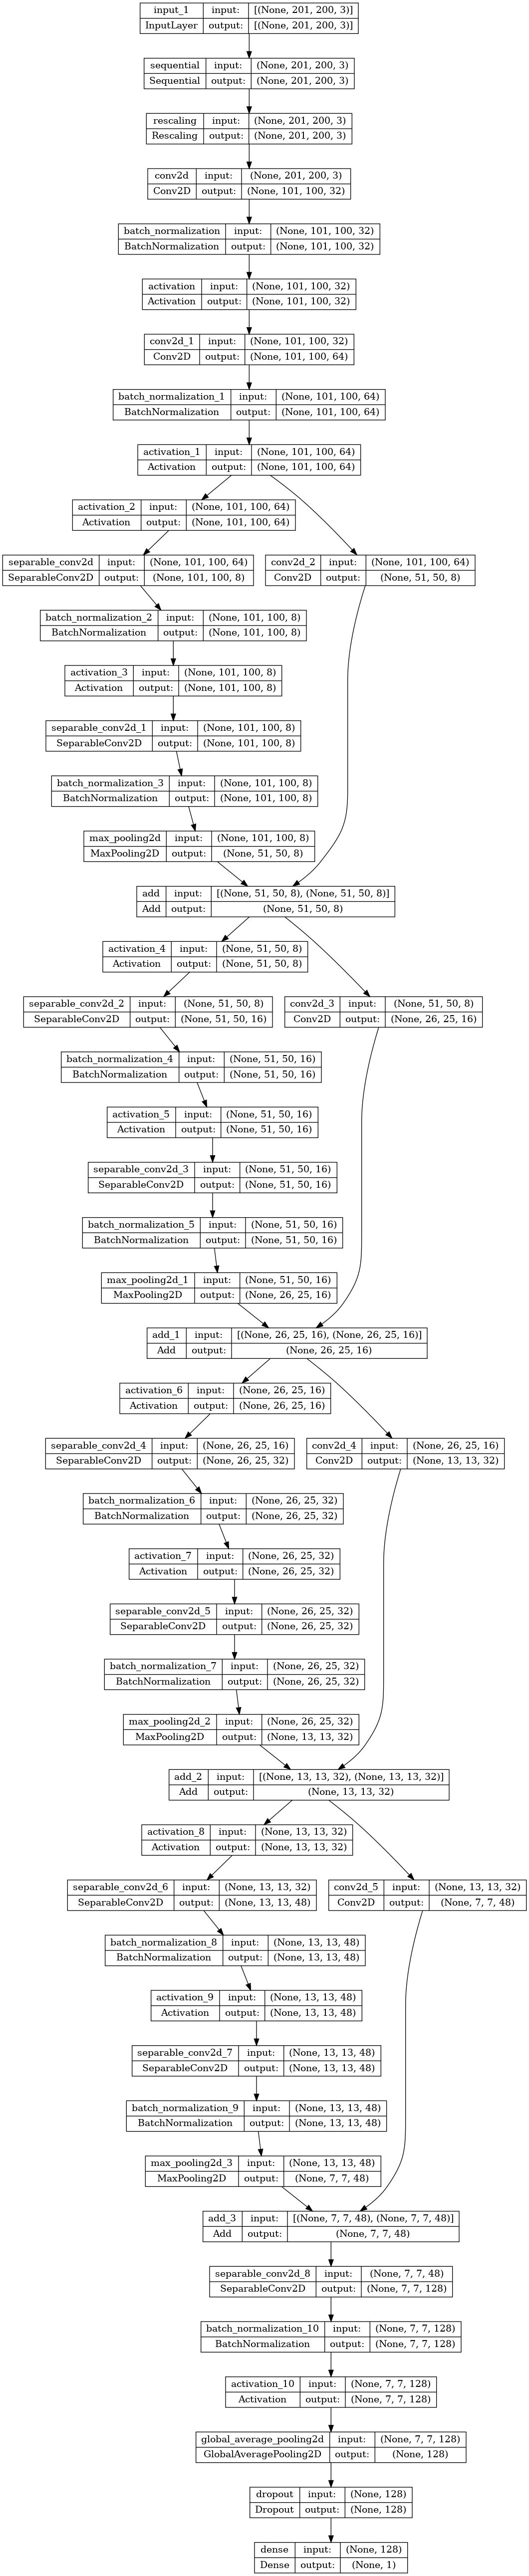

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

---

## 3. 모델 학습

In [ ]:
# /data/labeled 폴더에 어떤 class가 있는지 학인한다.
!ls data/labeled

abnormal  normal


- 학습데이터로 사용하는 GPR 이미지는 파형 변화가 없는 이미지(normal)와 파형 변화가 있는 이미지(abnormal), 2개로 구성된 이진 분류입니다.

- Keras에서는 class 별로 폴더를 나누어 놓으면 이를 읽어서 학습에 필요한 데이터 셋을 만드는 기능을 제공합니다.
- 아래 함수는 class 별로 나누어진 폴더를 지정하면 해당 폴더의 데이터를 읽어서 학습에 필요한 형태로 변환합니다.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/labeled",
    validation_split=0.1,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/labeled",
    validation_split=0.1,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 200 files belonging to 2 classes.
Using 180 files for training.
Found 200 files belonging to 2 classes.
Using 20 files for validation.


- 트레이닝 셋에 포함된 이미지 몇가지를 출력해 보겠습니다.

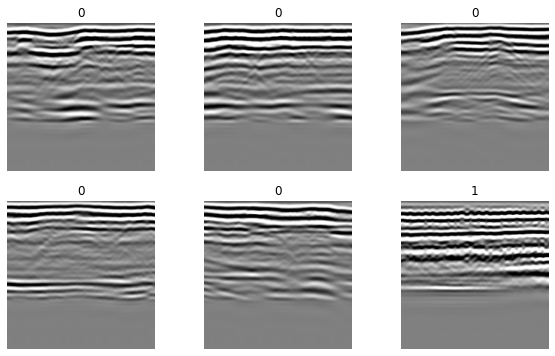

In [ ]:
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

- 이제 모델을 학습하겠습니다. 아래 코드를 수행하면 약 5~10분정도 소요됩니다. 느긋하게 기다려주세요.

In [ ]:
epochs = 30

# 학습과정에서 사용할 callback 함수를 정의합니다.
#  Keras에는 다양한 기능의 callback 함수가 있으며 자세한 내용은 https://keras.io/ko/callbacks/ 를 참고바랍니다.
callbacks = [
    # 가장 결과가 좋은 Model을 best.h5로 저장합니다.
    keras.callbacks.ModelCheckpoint("./models/best.h5", save_best_only=True, monitor='val_loss'),

    # 학습하는 과정에서 결과의 개선이 없으면 learning rate를 조절하는 callback 함수입니다.
    # patience 는 몇 회 동안 loss가 변하지 않으면 learning rate를 줄이는지 인내력 정하는 파라미터
    # mode 는 auto 면 알아서 판단해서 높은값이 좋은지, 낮은값이 좋은지 판단
    # min_delta 는 개선 되었다고 판단하는 최소 차이
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0),
]

# model을 학습하기 위한 optimizer와 평가방법을 지정합니다.
model.compile(
    # optimizer를 지정한다.
    optimizer=keras.optimizers.Adam(1e-3),
    # 사용할 loss function을 지정한다. class가 2개 이므로 binary crossentropy
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# 앞 단계에서 지정한 데이터 셋, 모델, callback 함수를 이용하여 모델의 학습을 수행합니다.
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/30
23/23 [==============================] - 16s 466ms/step - loss: 0.6955 - accuracy: 0.5944 - val_loss: 0.6893 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - 10s 431ms/step - loss: 0.6097 - accuracy: 0.6222 - val_loss: 0.6754 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - 10s 435ms/step - loss: 0.5283 - accuracy: 0.7389 - val_loss: 0.6490 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - 10s 428ms/step - loss: 0.5018 - accuracy: 0.7333 - val_loss: 0.6271 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/30
23/23 [==============================] - 10s 416ms/step - loss: 0.3872 - accuracy: 0.8222 - val_loss: 0.6081 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/30
23/23 [==============================] - 10s 409ms/step - loss: 0.3435 - accuracy: 0.8444 - val_loss: 0.6142 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 7/30
23/23 [==============================] - 9s 404ms/ste

---

## 4. 모델 추론

- 학습된 모델 파일을 로드하여 샘플 이미지를 추론하겠습니다.

1/1 [==============================] - 0s 295ms/step
This image is 0.07 percent abnormal and 99.93 normal.
1/1 [==============================] - 0s 25ms/step
This image is 97.61 percent abnormal and 2.39 normal.


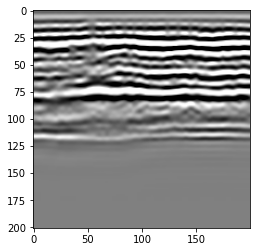

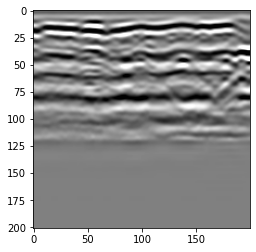

In [ ]:
# 가장 학습 결과가 좋은 모델을 로딩합니다.
model = tf.keras.models.load_model("./models/best.h5")

# 테스트를 위해서 정상 이미지 1장와 abnormal 이미지 1장을 로딩합니다.
normal_img = keras.preprocessing.image.load_img(
    "./data/labeled/normal/1613059433_516002_X_2.3793_Y_-35.1849_T_odom_20.8377_dir_-1.0_0.png", target_size=image_size
)

abnormal_img = keras.preprocessing.image.load_img(
"./data/labeled/abnormal/1613059614_8893247_X_12.9562_Y_-44.8245_T_odom_35.5064_dir_-1.0_0.png", target_size=image_size
)

# 이미지를 입력하면 predict를 수행하고 그 결과를 표시하는 함수를 하나 정의 합니다.
def predict_and_show(img):
    img_array = keras.preprocessing.image.img_to_array(img) # 한번에 이미지 여러장씩 넣으므로 배열로 넣음
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = predictions[0]
    # print(score)
    print( "This image is %.2f percent abnormal and %.2f normal." % (100 * (1 - score), 100 * score))

    plt.figure()
    plt.imshow(img, cmap='gray')

# normal 이미지를 입력하여 결과를 확인합니다.
predict_and_show(normal_img) # 정상이미지

# abnormal 이미지를 입력하여 결과를 확인합니다.
predict_and_show(abnormal_img) # 비정상이미지

- normal 이미지 추론 결과는 `abnormal = 0.28%, normal = 99.72%` 입니다.
- abnormal 이미지 추론 결과는 `abnormal = 99.09%, normal = 0.91%`입니다. 추론이 잘 수행된 것 같습니다.

---

## 퀴즈


아래 코드는 ResNet 모델에 기반한 학습 및 추론 코드입니다.

`None`으로 표시된 부분을 고쳐서 코드를 완성하세요.

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor: # 모델의 부분 중 하나
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = layers.add([x, y])
    out = relu_bn(out)
    return out

def make_resnet(input_shape, num_classes):
    num_filters = 4
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)

    x = BatchNormalization()(x)
    x = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(x)
    x = relu_bn(x)

    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            x = residual_block(x, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

resnet_model = make_resnet(input_shape=image_size + (3,), num_classes=2) # class 는 정상, 비정상 2개

- 모델을 시각화하려면 아래 코드를 실행하세요.

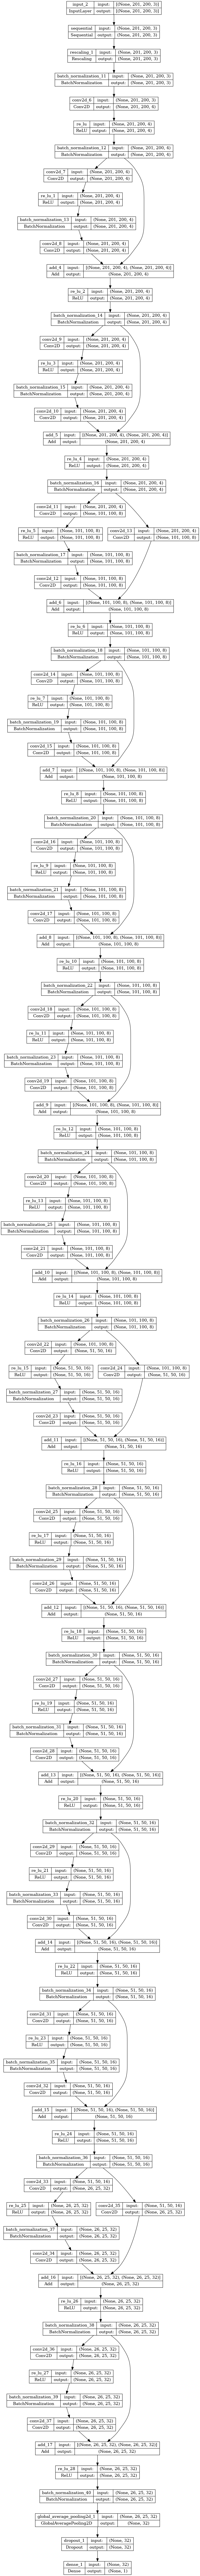

In [ ]:
keras.utils.plot_model(resnet_model, show_shapes=True)

In [ ]:
epochs = 20
callbacks = [
    keras.callbacks.ModelCheckpoint("./models/resnet_best.h5", save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.00001, cooldown=0, min_lr=0),
]

resnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

resnet_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20
23/23 [==============================] - 34s 1s/step - loss: 0.7046 - accuracy: 0.5278 - val_loss: 0.6816 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - 23s 1s/step - loss: 0.6505 - accuracy: 0.6667 - val_loss: 0.6241 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - 23s 1s/step - loss: 0.5485 - accuracy: 0.7389 - val_loss: 0.6152 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/20
23/23 [==============================] - 23s 987ms/step - loss: 0.4060 - accuracy: 0.8500 - val_loss: 1.4251 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/20
23/23 [==============================] - 23s 981ms/step - loss: 0.3427 - accuracy: 0.8778 - val_loss: 0.7246 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/20
23/23 [==============================] - 23s 1s/step - loss: 0.3998 - accuracy: 0.8278 - val_loss: 0.7083 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 7/20
23/23 [==============================] - 23s 981ms/step - loss: 0

- 아래 코드를 수행하면 동일한 샘플 이미지를 추론합니다.
- 추론 결과가 조금 다른 것을 확인할 수 있습니다. 비교해보세요.

1/1 [==============================] - 1s 504ms/step
This image is 11.42 percent abnormal and 88.58 normal.
1/1 [==============================] - 0s 35ms/step
This image is 56.86 percent abnormal and 43.14 normal.


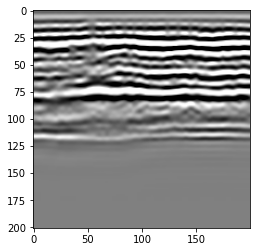

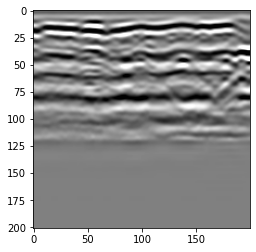

In [ ]:
resnet_model = tf.keras.models.load_model("./models/resnet_best.h5")
normal_img = keras.preprocessing.image.load_img(
    "./data/labeled/normal/1613059433_516002_X_2.3793_Y_-35.1849_T_odom_20.8377_dir_-1.0_0.png", target_size=image_size
)
abnormal_img = keras.preprocessing.image.load_img(
"./data/labeled/abnormal/1613059614_8893247_X_12.9562_Y_-44.8245_T_odom_35.5064_dir_-1.0_0.png", target_size=image_size
)

# 이미지를 입력하면 predict를 수행하고 그 결과를 표시하는 함수를 하나 정의 합니다.
def predict_and_show(img):
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = resnet_model.predict(img_array)
    score = predictions[0]
    print( "This image is %.2f percent abnormal and %.2f normal." % (100 * (1 - score), 100 * score))
    plt.figure()
    plt.imshow(img, cmap='gray')

predict_and_show(normal_img)
predict_and_show(abnormal_img)
